# EDA & modelization

## Loading main packages 

In [1]:
from EZS_func import *
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import re
import math
from pandas.api.types import is_numeric_dtype
from itertools import product
from scipy import stats
from sklearn import set_config
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.inspection import permutation_importance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import feature_importances
from yellowbrick.features import rank1d
from yellowbrick.features import rank2d
from yellowbrick.regressor import prediction_error
from yellowbrick.regressor import residuals_plot
from yellowbrick.contrib.missing import MissingValuesBar
from yellowbrick.contrib.missing import MissingValuesDispersion
from yellowbrick.target.feature_correlation import feature_correlation
from xgboost import XGBRegressor
from xgboost import plot_tree
from xgboost import to_graphviz


## Exploratory Data Analysis 

### File and parameters loading

In [2]:
problem_type = 'regression'

In [3]:
stacking = 'True'

In [4]:
data_size = 'large'

In [5]:
df = pd.read_csv('/home/philippe/Documents/python project/EZStacking-v0.5/dataset/synchronous machine.csv')

In [6]:
target_col = 'If'

In [7]:
user_drop_cols = []

In [8]:
threshold_NaN = 0.5

In [9]:
threshold_cat = 5

In [10]:
threshold_Z = 3.0

### Dataset Information

In [11]:
df.shape

(557, 5)

Some records

In [12]:
display(df)

,Iy,PF,e,dIf,If
0,3.0,0.66,0.34,0.383,1.563
1,3.0,0.68,0.32,0.372,1.552
2,3.0,0.70,0.30,0.360,1.540
3,3.0,0.72,0.28,0.338,1.518
4,3.0,0.74,0.26,0.317,1.497
...,...,...,...,...,...
552,6.0,0.91,0.09,0.142,1.322
553,6.0,0.93,0.07,0.151,1.331
554,6.0,0.95,0.05,0.160,1.340
555,6.0,0.97,0.03,0.160,1.340


### Dataframe structure

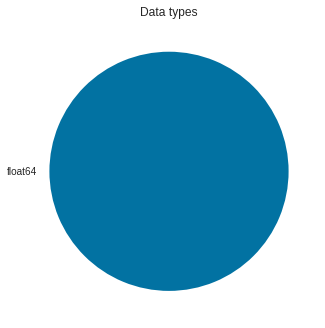

In [13]:
plot_dataframe_structure(df)

### Dataframe statistics

In [14]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Iy,557.0,4.499820,0.896024,3.000,3.700,4.500,5.300,6.000
PF,557.0,0.825296,0.103925,0.650,0.740,0.820,0.920,1.000
e,557.0,0.174704,0.103925,0.000,0.080,0.180,0.260,0.350
dIf,557.0,0.350659,0.180566,0.037,0.189,0.345,0.486,0.769
If,557.0,1.530659,0.180566,1.217,1.369,1.525,1.666,1.949


Which columns could be categorical ?

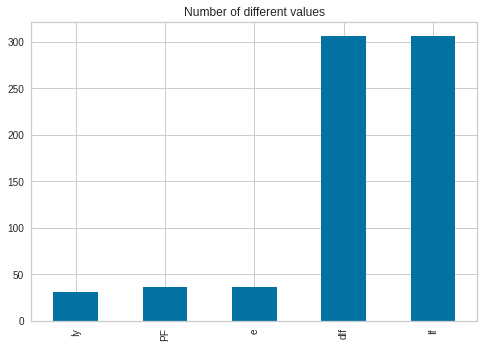

In [15]:
plot_categorical(df)

### Dataset Cleaning

#### Duplicate rows:

In [16]:
duplicates(df)

No duplicate rows.


,Iy,PF,e,dIf,If
0,3.0,0.66,0.34,0.383,1.563
1,3.0,0.68,0.32,0.372,1.552
2,3.0,0.70,0.30,0.360,1.540
3,3.0,0.72,0.28,0.338,1.518
4,3.0,0.74,0.26,0.317,1.497
...,...,...,...,...,...
552,6.0,0.91,0.09,0.142,1.322
553,6.0,0.93,0.07,0.151,1.331
554,6.0,0.95,0.05,0.160,1.340
555,6.0,0.97,0.03,0.160,1.340


#### Drop user's columns:

In [17]:
print('user_drop_cols = ', user_drop_cols)

user_drop_cols =  []


In [18]:
df = df.drop(user_drop_cols, axis=1)

#### Drop NaN:

In [19]:
df, drop_cols = drop_na(df, threshold_NaN)

No need to drop columns.


Final set of dropped columns

In [20]:
dropped_cols = np.unique(np.concatenate((drop_cols, user_drop_cols)))

In [21]:
display(dropped_cols)

array([], dtype=float64)

#### Encoding data:

In [22]:
df, encoded_cols = encoding(df, threshold_cat)

Encoding numeric column: Iy
Encoding numeric column: PF
Encoding numeric column: e
Encoding numeric column: dIf
Encoding numeric column: If


#### Imputing NaN using IterativeImputer

No handles with labels found to put in legend.


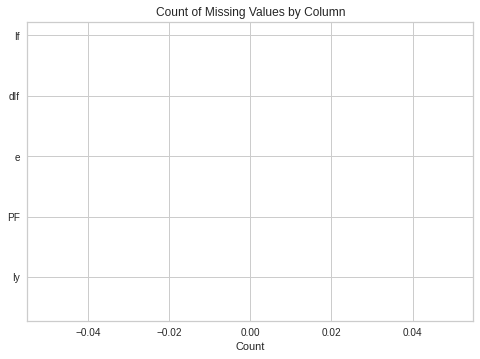

In [23]:
visualizer = MissingValuesBar(features=df.select_dtypes(include=np.number).columns.tolist())
visualizer.fit(df.select_dtypes(include=np.number))
visualizer.show();

##### Imputation

In [24]:
df = imputation(df)

No need to impute data.


#### Data compression:

In [25]:
df = downcast_dtypes(df)

Memory usage of dataframe is 0.02MB
Memory usage after optimization is: 0.01MB
Decreased by 74.6%


Dataframe structure after compression

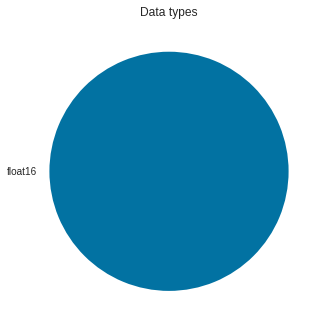

In [26]:
plot_dataframe_structure(df)

#### Outliers:

In [27]:
df = outliers(df, threshold_Z)

Using Z_score,  0  rows will be suppressed.


#### Splitting dataframe in features and targets

In [28]:
y = df[target_col]

In [29]:
X = df.drop(target_col, axis=1)

### Plottings

#### Ranking 

##### Ranking 1D 

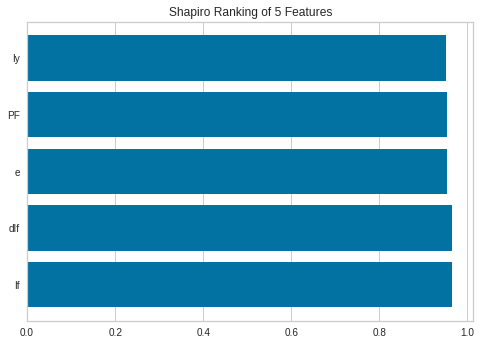

In [30]:
rank1d(df);

##### Ranking 2D 

###### Ranking 2D according to Pearson

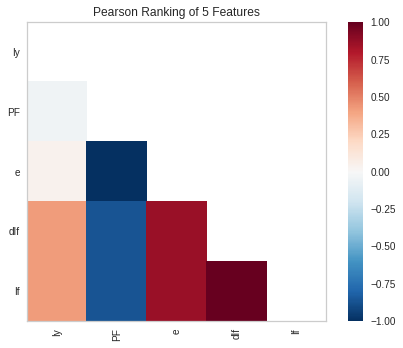

In [31]:
rank2d(df, algorithm='pearson');

###### Ranking 2D based on covariance

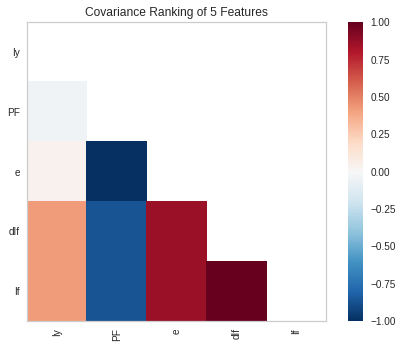

In [32]:
rank2d(df, algorithm='covariance');

###### Ranking 2D according to Spearman

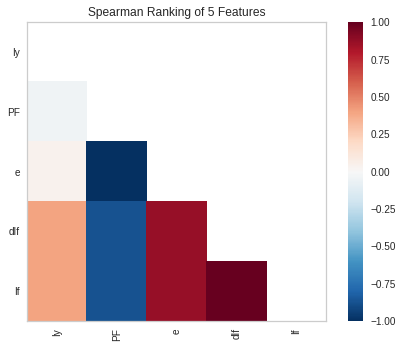

In [33]:
rank2d(df, algorithm='spearman');

###### Ranking 2D according to Kendalltau

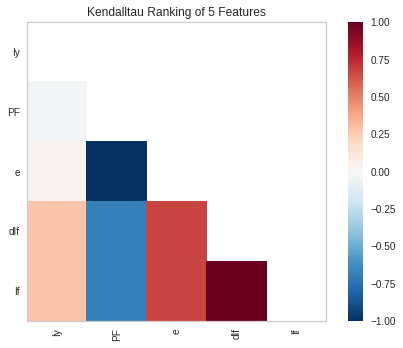

In [34]:
rank2d(df, algorithm='kendalltau');

#### Correlation

##### Correlation with Yellow Bricks

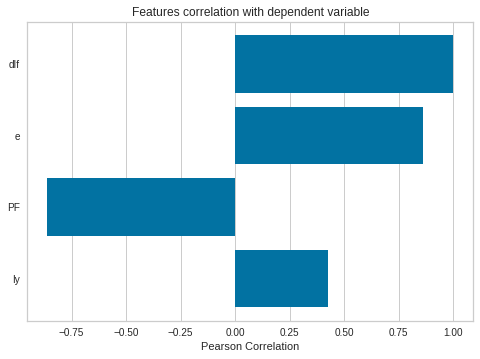

In [35]:
feature_correlation(X, y);

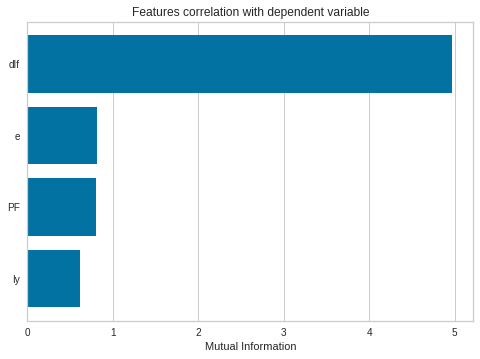

In [36]:
feature_correlation(X, y, method='mutual_info-regression');

#### Feature importance (a priori)

##### According to decision tree

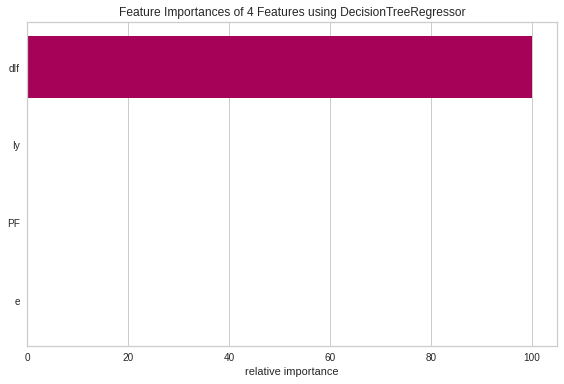

In [37]:
feature_importances(DecisionTreeRegressor(), X, y);

##### According to elasticnet regression

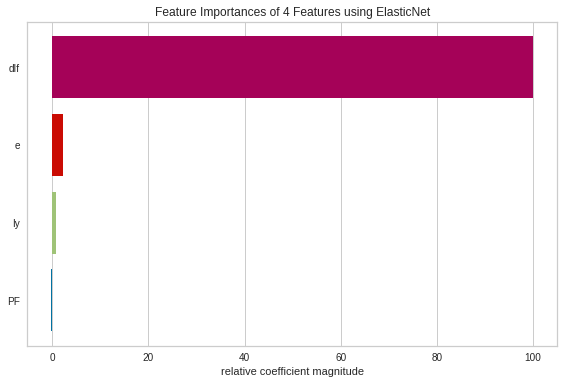

In [38]:
feature_importances(ElasticNet(alpha=0.01, l1_ratio=0.5), X, y);

## Splitting data in train and test sets 

In [39]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.33)

## Modeling

### Building the model

Level-0 models

In [40]:
level_0 = [ 
          ( 'RFR' , RandomForestRegressor(max_depth=5, n_estimators=10, max_features='auto') ), 
          ( 'ABR' , AdaBoostRegressor() ), 
          ( 'SGDR' , SGDRegressor(loss='squared_loss') ), 
          ( 'ELNE' , ElasticNet(alpha=0.01, l1_ratio=0.5) ), 
          ( 'SVRL' , SVR(kernel='linear') ), 
          ( 'SVRP' , SVR(kernel='poly') ), 
          ( 'SVRG' , SVR(kernel='rbf') ), 
          ( 'XGBR' , XGBRegressor(max_depth=5, n_estimators=20, verbosity=0) ), 
          ]

Level-1 model

In [41]:
level_1 = MLPRegressor()

Stacking for regression

In [42]:
model = StackingRegressor(level_0, final_estimator=level_1)

### Model fitting

In [43]:
%%time
set_config(display='diagram') 
model.fit(X_train, y_train)

CPU times: user 2.15 s, sys: 309 ms, total: 2.46 s
Wall time: 1.5 s


StackingRegressor(estimators=[('RFR',
                               RandomForestRegressor(max_depth=5,
                                                     n_estimators=10)),
                              ('ABR', AdaBoostRegressor()),
                              ('SGDR', SGDRegressor()),
                              ('ELNE', ElasticNet(alpha=0.01)),
                              ('SVRL', SVR(kernel='linear')),
                              ('SVRP', SVR(kernel='poly')), ('SVRG', SVR()),
                              ('XGBR',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample...
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=5,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=20, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=None,
                                            reg_lambda=None,
                                            scale_pos_weight=None,
                                            subsample=None, tree_method=None,
                                            validate_parameters=None,
                                            verbosity=0))],
                  final_estimator=MLPRegressor())

### Model evaluation

#### Model scoring

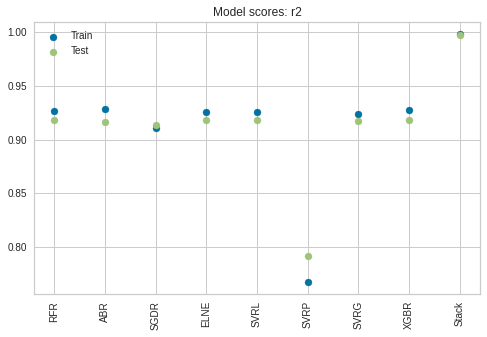

array([['RFR', 0.9266968682680392, 0.9186730325879007],
       ['ABR', 0.928122429298786, 0.916206120794405],
       ['SGDR', 0.9107097189245327, 0.9132909399654634],
       ['ELNE', 0.9254653064257723, 0.91806023231379],
       ['SVRL', 0.9261452229451832, 0.9179599610808844],
       ['SVRP', 0.7676951926632924, 0.7912351201699028],
       ['SVRG', 0.9241620684566968, 0.9175611469413592],
       ['XGBR', 0.9279111653840203, 0.918524633062345],
       ['Stack', 0.9979787484888507, 0.9978428642047622]], dtype=object)

In [44]:
score_stacking_r(model, X_train, y_train, X_test, y_test)

#### Feature permutation importance (a posteriori)

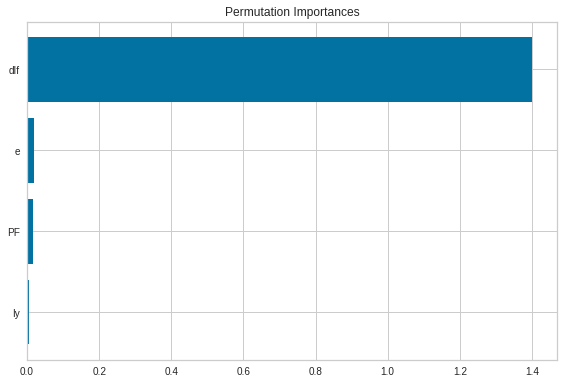

In [45]:
plot_perm_imp(model, X, y, scoring = 'r2');

#### Residuals plot

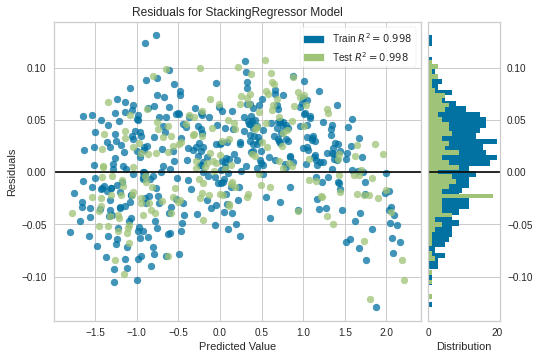

In [46]:
residuals_plot(model, X_train, y_train, X_test, y_test);

#### Prediction error

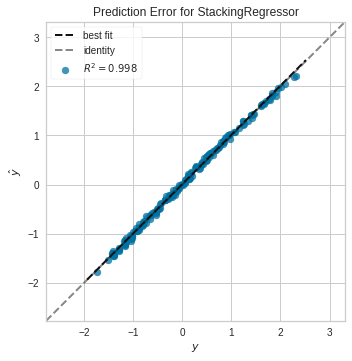

In [47]:
prediction_error(model, X_train, y_train, X_test, y_test);